In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms
from pathlib import Path
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
# Create Dataset class
class Create_Dataset(Dataset):
    def __init__(self, folder_path, transforms=None):
        super().__init__()
        self.folder_path = Path(folder_path)
        self.img_files = list(self.folder_path.glob("Image/*.jpg"))
        self.mask_files = [self.folder_path / "Mask" / f"{img_file.stem}.png" for img_file in self.img_files]

        if transforms:
            self.transforms = transforms
    def __getitem__(self, index):
        img = Image.open(self.img_files[index]).convert("RGB")  # Ensure RGB mode
        mask = Image.open(self.mask_files[index])  

        if transforms:
            img = self.transforms(img)
            mask = self.transforms(mask)

        return img, mask

    def __len__(self):
        return len(self.img_files)


In [3]:
# Create dataset using custom class
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])
dataset = Create_Dataset("../../Data/Flood Segmentation",transform)
len(dataset)

290

Text(0.5, 1.0, 'Mask')

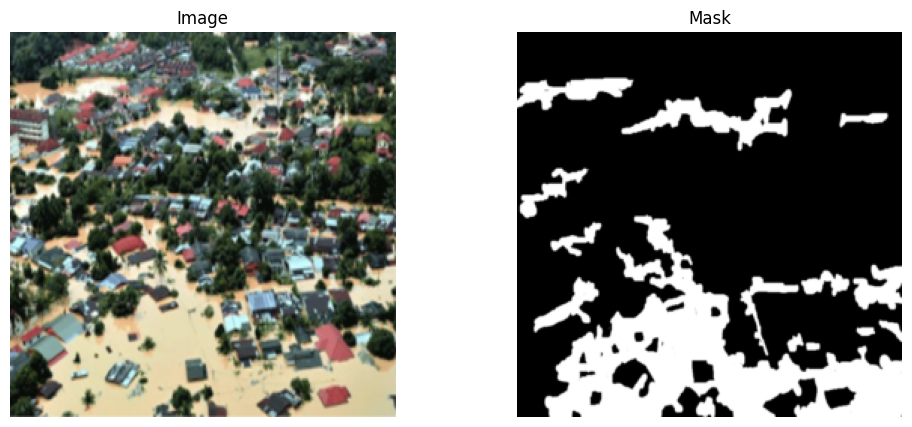

In [4]:
# plot images from dataset
img, mask = next(iter(dataset))
_, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].imshow(img.permute(1,2,0))
ax[0].axis(False)
ax[0].set_title('Image')
ax[1].imshow(mask.permute(1,2,0),cmap='gray')
ax[1].axis(False)
ax[1].set_title('Mask')

In [5]:
# Split dataset into train and test
lengths = [int(0.9*len(dataset)), int(0.1*len(dataset))]
train_dataset, test_dataset = random_split(dataset, lengths)
print(len(train_dataset),len(test_dataset))

261 29


In [6]:
# Create Dataloader
BATCH_SIZE = 32
train_dataloader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle=True,
    num_workers = 0
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [7]:
# Create model class
class Segmentation_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=100,kernel_size=5,stride=2,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            nn.Conv2d(in_channels=100, out_channels=200,kernel_size=5,stride=2,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            nn.Conv2d(in_channels=200, out_channels=300,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=300, out_channels=300,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=300, out_channels=2,kernel_size=1,stride=1,padding=0),
            nn.ReLU()
        )
        self.segmentation = nn.ConvTranspose2d(in_channels=2,out_channels=2,kernel_size=31,stride=17,padding=15)
    def forward(self,x):
        return self.segmentation(self.feature_extractor(x))

In [8]:
model = Segmentation_model()

In [9]:
summary(model,
        input_size=(32,3,256,256),
       col_names=['input_size','output_size','num_params','trainable'],
       row_settings=['var_names'])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
Segmentation_model (Segmentation_model)  [32, 3, 256, 256]         [32, 2, 256, 256]         --                        True
├─Sequential (feature_extractor)         [32, 3, 256, 256]         [32, 2, 16, 16]           --                        True
│    └─Conv2d (0)                        [32, 3, 256, 256]         [32, 100, 128, 128]       7,600                     True
│    └─ReLU (1)                          [32, 100, 128, 128]       [32, 100, 128, 128]       --                        --
│    └─MaxPool2d (2)                     [32, 100, 128, 128]       [32, 100, 64, 64]         --                        --
│    └─Conv2d (3)                        [32, 100, 64, 64]         [32, 200, 32, 32]         500,200                   True
│    └─ReLU (4)                          [32, 200, 32, 32]         [32, 200, 32, 32]         --                        --
│    └─Ma

In [10]:
# Create dice loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth # added to avoid division by zero

    def forward(self, y_pred, y_true):
        """
        y_pred: [B, C, H, W] - raw logits from model (before softmax)
        y_true: [B, 1, H, W] - class indices (0 to C-1)
        """
        B, C, H, W = y_pred.shape
        # Apply softmax to get class probabilities
        y_pred_soft = F.softmax(y_pred, dim=1)
        # Convert y_true from [B, 1, H, W] → [B, C, H, W] (one-hot)
        y_true_one_hot = torch.zeros_like(y_pred_soft)
        y_true_one_hot.scatter_(1, y_true.long(), 1)  # one-hot encoding
        # Flatten
        y_pred_flat = y_pred_soft.contiguous().view(B, C, -1)
        y_true_flat = y_true_one_hot.contiguous().view(B, C, -1)

        intersection = (y_pred_flat * y_true_flat).sum(dim=2)
        union = y_pred_flat.sum(dim=2) + y_true_flat.sum(dim=2)
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        loss = 1 - dice  # shape: [B, C]
        return loss.mean()  # mean over batch and classes

In [11]:
# setup before training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
loss_fn = DiceLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

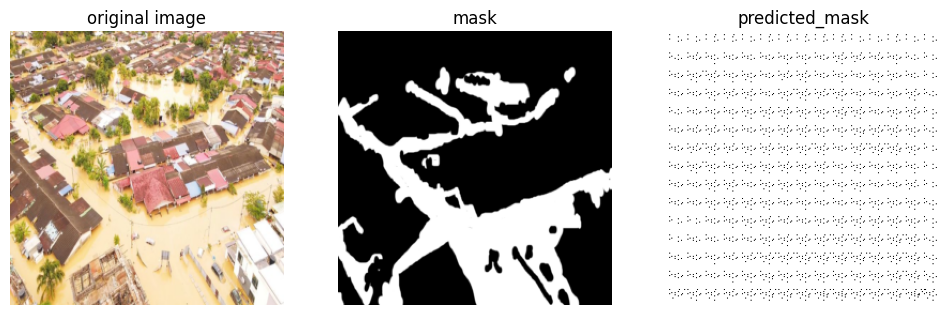

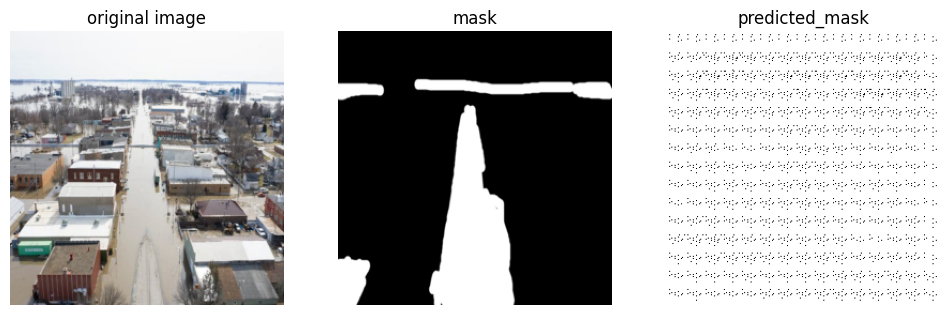

In [12]:
# function to plot prediction
def show_prediction(img, mask):
    out = model(img.unsqueeze(dim=0).to(device))
    out = out.detach().to('cpu')
    _, ax = plt.subplots(1,3, figsize=(12,5))
    ax[0].imshow(img.permute(1,2,0))
    ax[0].axis(False)
    ax[0].set_title("original image")
    ax[1].imshow(mask.permute(1,2,0), cmap='gray')
    ax[1].axis(False)
    ax[1].set_title("mask")
    ax[2].imshow(torch.argmax(out, dim=1, keepdim=True)[0].permute(1,2,0), cmap='gray')
    ax[2].axis(False)
    ax[2].set_title("predicted_mask")
    # ax[1].imshow(out[1].unsqueeze(-1), cmap='gray')

def plot_predictions(num_imgs):
    count = 0
    for i,m in test_dataloader:
        for x,y in zip(i,m):
            show_prediction(x,y)
            count += 1
            if count == num_imgs:
                break
plot_predictions(2)

In [13]:
# train model
EPOCHS=100
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}:",end=' ')
    model.train()
    train_loss = 0
    for X,y in train_dataloader:
        X,y = X.to(device),y.to(device)
        out = model(X)
        loss = loss_fn(out, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for X,y in test_dataloader:
            X,y = X.to(device), y.to(device)
            out = model(X)
            test_loss += loss_fn(out,y).item()
        test_loss /= len(test_dataloader)
        scheduler.step() # LR scheduler
        print(f"train loss: {train_loss:.4f}, test loss: {test_loss:.4f}")
        # plot_predictions(1)
        # plt.show()

Epoch 1/100: train loss: 0.5259, test loss: 0.5221
Epoch 2/100: train loss: 0.5160, test loss: 0.5048
Epoch 3/100: train loss: 0.4924, test loss: 0.4991
Epoch 4/100: train loss: 0.4746, test loss: 0.4148
Epoch 5/100: train loss: 0.3972, test loss: 0.3580
Epoch 6/100: train loss: 0.3164, test loss: 0.3256
Epoch 7/100: train loss: 0.2970, test loss: 0.3625
Epoch 8/100: train loss: 0.2884, test loss: 0.3266
Epoch 9/100: train loss: 0.2872, test loss: 0.3078
Epoch 10/100: train loss: 0.2750, test loss: 0.2919
Epoch 11/100: train loss: 0.2613, test loss: 0.3061
Epoch 12/100: train loss: 0.2596, test loss: 0.2893
Epoch 13/100: train loss: 0.2484, test loss: 0.2614
Epoch 14/100: train loss: 0.2448, test loss: 0.2618
Epoch 15/100: train loss: 0.2394, test loss: 0.2552
Epoch 16/100: train loss: 0.2364, test loss: 0.2637
Epoch 17/100: train loss: 0.2448, test loss: 0.2692
Epoch 18/100: train loss: 0.2454, test loss: 0.2489
Epoch 19/100: train loss: 0.2338, test loss: 0.2723
Epoch 20/100: train l

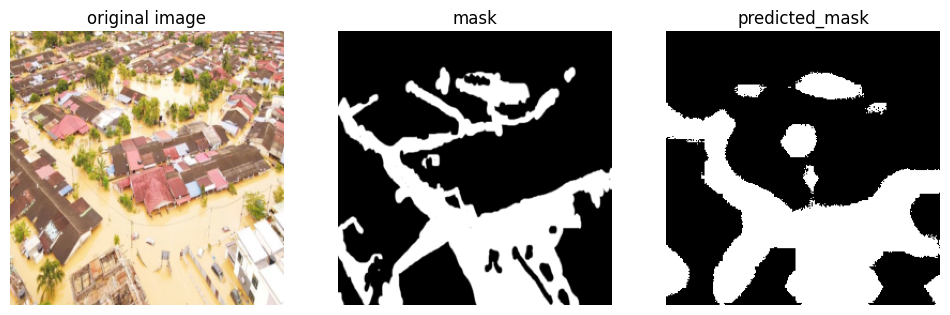

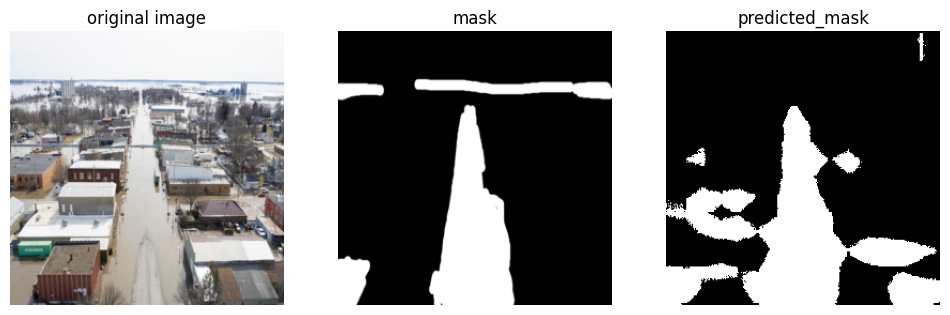

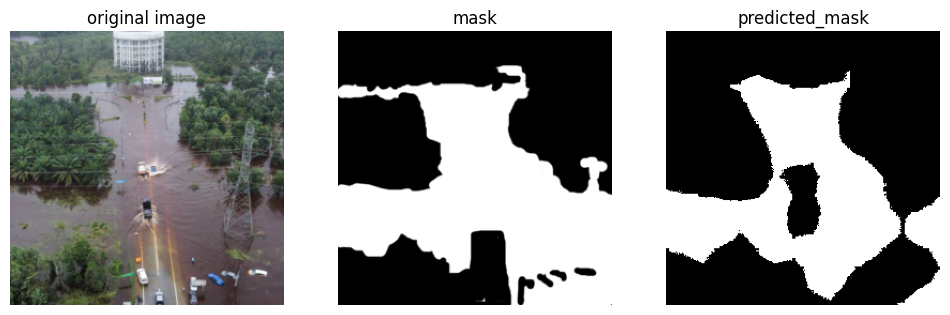

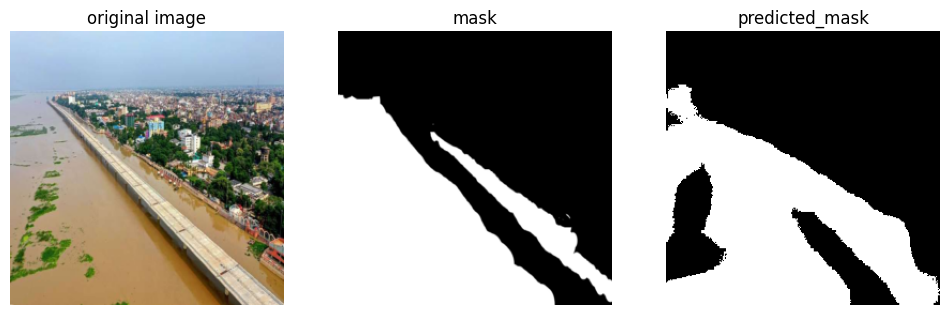

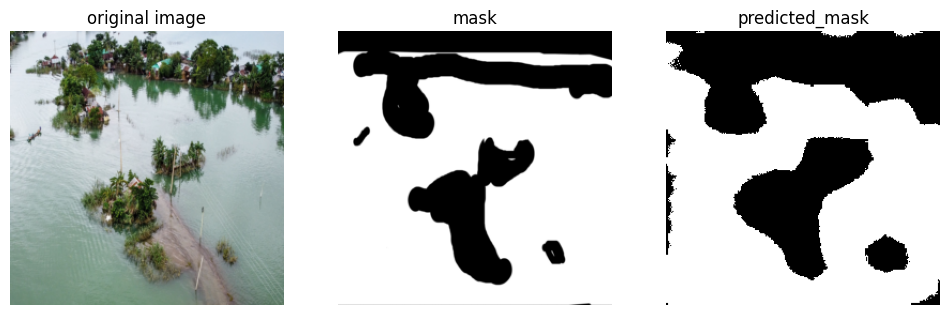

In [14]:
# plot results after training
plot_predictions(5)

In [15]:
torch.save(model.state_dict(), 'flood_seg_weights.pth')